Quick look at pre-release v3.1 results

Runs in here:
* Previous baselines
    * `retro_baseline_v2.0_10yrs.db` (like v1.x runs)
    * `baseline_v2.0_10yrs.db`
    * `baseline_v2.1_10yrs.db`
    * `baseline_v2.2_10yrs.db`
    * `baseline_v3.0_10yrs.db`
* `starter_v3.1_10yrs.db`
    * update to the footprint to include small Euclid swath
    * update survey start time
    * uzy filter swapping rather than just uz
    * updated to newer cloud database
    * telescope now parks with r-filter in. Should be no filter change time added when coming out of park.
    * updated long gaps survey to only attempt log gaps if early pair was sucessful
    * blobs no longer have az and radius limits (mostly a change for visulization)
    

Runs below are like starter_v3.1 except how noted.

* `m2_starter`
    * same as `starter`, but run on apple silicon. Mostly for checking cross-platform repeatability
* `filtlers_uy`
    * swaps y in for u in bright time
* `filters_uz`
    * swaps z in for u in bright time (like previous baselines)
* `noroll`
    * no rolling candence. Requested by DESC to look at uniformity at data releases
* `old_mjd0_uz`
    * rolling back the survey start date, swapping only u and z filters
* `old_mjd0`
    * rolling back survey start date, swapping u with z & y
* `threeroll`
    * only three seasons of rolling. Looking at final survey uniformity
*  `weather_cloudso...`
    * Varying the start year of our cloud database. Provides a handy way to look at the precision of metric values and the limits to which we can expect to optimize the survey
* `no_plane`, `light_plane`, `heavy_plane`
    * Varying the amount of observing in the dusty plane. Mostly so we can check self calibration schemes. 



In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:
data_loaded = pd.read_hdf('summary.h5')

In [4]:
# [col for col in data_loaded.columns if 'KNe' in col and 'ztf' in col]

In [5]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'best18k parallax HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
             'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira'}

# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'Vatira': 'fraction'
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 

In [6]:
data

,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N","SNe, zlim",3x2 i-band,WL Nvis \ni-band,KNe ZTF simple,KNe single model,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,Vatira
baseline_v2.0_10yrs,0.791058,0.184088,0.3116,0.4284,839.0,99302.532220,0.282012,37.908126,443.0,3433.0,4544.0,1879.0,168086.074111,0.9294,0.642021,0.719635,0.0039
baseline_v2.1_10yrs,0.806910,0.188258,0.3111,0.4312,838.0,99294.339899,0.283756,38.560143,443.0,3585.0,4777.0,1918.0,163815.013503,0.9286,0.647553,0.723197,0.0017
baseline_v2.2_10yrs,0.792958,0.186345,0.3212,0.4462,830.0,112802.099640,0.289980,39.794283,440.0,3950.0,5215.0,1920.0,172453.127988,0.9304,0.657476,0.723913,0.0008
baseline_v3.0_10yrs,0.792666,0.185683,0.3239,0.4559,795.0,109475.798536,0.293926,38.643260,423.0,4308.0,5654.0,1950.0,168032.537231,0.9326,0.642155,0.722293,0.0376
filters_uy_v3.1_10yrs,0.811122,0.188370,0.3352,0.4720,790.0,118880.292686,0.302762,39.142976,420.0,3490.0,5343.0,2019.0,171403.415317,0.9290,0.636783,0.721427,0.0413
filters_uz_v3.1_10yrs,0.803478,0.188807,0.3262,0.4557,791.0,116210.047327,0.297961,39.080035,421.0,3882.0,5771.0,1992.0,171472.439702,0.9284,0.638064,0.722168,0.0494
heavy_plane_v3.1_10yrs,0.793423,0.187699,0.3212,0.4543,709.0,102159.161384,0.292899,37.672911,373.0,3032.0,4618.0,1996.0,178674.531197,0.9260,0.636615,0.721500,0.0424
light_plane_v3.1_10yrs,0.816620,0.190140,0.3192,0.4427,828.0,123724.846659,0.302334,39.507512,440.0,3727.0,5738.0,1960.0,165760.094451,0.9284,0.636188,0.717711,0.0423
m2_starter_v3.1_10yrs,0.813654,0.188392,0.3284,0.4634,787.0,115624.034877,0.300479,38.911159,418.0,3461.0,5318.0,1980.0,170926.339968,0.9304,0.635711,0.722715,0.0514
noroll_v3.1_10yrs,0.789433,0.185657,0.3454,0.4699,782.0,114804.168960,0.278487,39.435785,414.0,3139.0,4565.0,2068.0,176142.009785,0.9258,0.638554,0.721085,0.0427


In [7]:
data['KNe single model'] # data['KNe ZTF simple']

baseline_v2.0_10yrs            4544.0
baseline_v2.1_10yrs            4777.0
baseline_v2.2_10yrs            5215.0
baseline_v3.0_10yrs            5654.0
filters_uy_v3.1_10yrs          5343.0
filters_uz_v3.1_10yrs          5771.0
heavy_plane_v3.1_10yrs         4618.0
light_plane_v3.1_10yrs         5738.0
m2_starter_v3.1_10yrs          5318.0
noroll_v3.1_10yrs              4565.0
old_mjd0_uz_v3.1_10yrs         5662.0
old_mjd0_v3.1_10yrs            5170.0
retro_baseline_v2.0_10yrs      3982.0
starter_v3.1_10yrs             5246.0
threeroll_v3.1_10yrs           5139.0
weather_cloudso0v3.1_10yrs     5246.0
weather_cloudso10v3.1_10yrs    5502.0
weather_cloudso12v3.1_10yrs    5577.0
weather_cloudso14v3.1_10yrs    5667.0
weather_cloudso16v3.1_10yrs    5639.0
weather_cloudso18v3.1_10yrs    5518.0
weather_cloudso1v3.1_10yrs     5496.0
weather_cloudso20v3.1_10yrs    5402.0
weather_cloudso2v3.1_10yrs     5648.0
weather_cloudso30v3.1_10yrs    5354.0
weather_cloudso31v3.1_10yrs    5424.0
weather_clou

In [8]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated
data['KNe ZTF simple']

baseline_v2.0_10yrs            3433.0
baseline_v2.1_10yrs            3585.0
baseline_v2.2_10yrs            3950.0
baseline_v3.0_10yrs            4308.0
filters_uy_v3.1_10yrs          3490.0
filters_uz_v3.1_10yrs          3882.0
heavy_plane_v3.1_10yrs         3032.0
light_plane_v3.1_10yrs         3727.0
m2_starter_v3.1_10yrs          3461.0
noroll_v3.1_10yrs              3139.0
old_mjd0_uz_v3.1_10yrs         4354.0
old_mjd0_v3.1_10yrs            4023.0
retro_baseline_v2.0_10yrs      2763.0
starter_v3.1_10yrs             3442.0
threeroll_v3.1_10yrs           3407.0
weather_cloudso0v3.1_10yrs     3442.0
weather_cloudso10v3.1_10yrs    3503.0
weather_cloudso12v3.1_10yrs    3711.0
weather_cloudso14v3.1_10yrs    3634.0
weather_cloudso16v3.1_10yrs    3866.0
weather_cloudso18v3.1_10yrs    3668.0
weather_cloudso1v3.1_10yrs     3723.0
weather_cloudso20v3.1_10yrs    3511.0
weather_cloudso2v3.1_10yrs     3746.0
weather_cloudso30v3.1_10yrs    3574.0
weather_cloudso31v3.1_10yrs    3533.0
weather_clou

In [9]:
mag_data

,g,i,r,u,y,z
baseline_v2.0_10yrs,26.733479,26.218659,26.755971,25.818916,24.762720,25.510379
baseline_v2.1_10yrs,26.736248,26.252054,26.781543,25.751969,24.728145,25.486640
baseline_v2.2_10yrs,26.753646,26.290929,26.835430,25.724699,24.782743,25.581317
baseline_v3.0_10yrs,26.688123,26.264600,26.818287,25.668262,24.756955,25.524781
filters_uy_v3.1_10yrs,26.689200,26.280034,26.799565,25.669360,24.759448,25.574276
filters_uz_v3.1_10yrs,26.693787,26.276927,26.820730,25.662231,24.768174,25.551577
heavy_plane_v3.1_10yrs,26.688183,26.253991,26.791762,25.677495,24.747942,25.561547
light_plane_v3.1_10yrs,26.685899,26.290325,26.811116,25.675613,24.787338,25.585224
m2_starter_v3.1_10yrs,26.689347,26.273661,26.802231,25.660446,24.763780,25.559070
noroll_v3.1_10yrs,26.698129,26.285288,26.829763,25.708701,24.771984,25.582673


In [10]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS
baseline_v2.0_10yrs,47.333916,5.217382,NaN,81.438800,72.445437,0.596891,0.543027,NaN,0.593426,0.562289
baseline_v2.1_10yrs,21.899369,2.592571,NaN,40.212476,32.838014,0.594427,0.545216,NaN,0.594464,0.561932
baseline_v2.2_10yrs,13.647867,6.881372,NaN,3.753806,NaN,0.514987,0.577431,NaN,0.600156,NaN
baseline_v3.0_10yrs,362.726856,72.383449,74.734786,37.378088,60.363667,0.594675,0.575080,0.526724,0.546128,0.539335
filters_uy_v3.1_10yrs,392.762377,65.763333,119.798358,32.023350,52.775023,0.597429,0.571426,0.529098,0.596548,0.572319
filters_uz_v3.1_10yrs,374.244952,61.068424,110.006605,30.513217,53.148605,0.596875,0.562607,0.510613,0.577669,0.564340
heavy_plane_v3.1_10yrs,493.533022,266.220160,461.965305,179.479383,201.573909,0.590078,0.578689,0.528652,0.567352,0.567267
light_plane_v3.1_10yrs,491.971514,269.269845,460.472229,180.233452,203.569531,0.593998,0.578768,0.527194,0.569540,0.565674
m2_starter_v3.1_10yrs,494.101139,264.355229,461.416787,180.259516,206.582135,0.591394,0.578959,0.528695,0.569635,0.564779
noroll_v3.1_10yrs,494.925073,267.866337,465.262494,178.794823,203.893332,0.593970,0.580007,0.529172,0.569159,0.567492


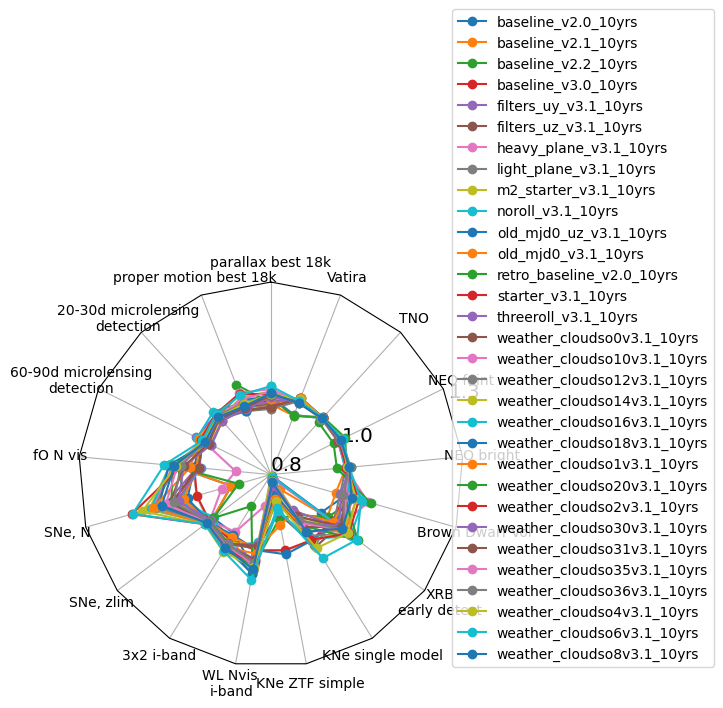

In [11]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.3], bbox_to_anchor=(1.65, 0))

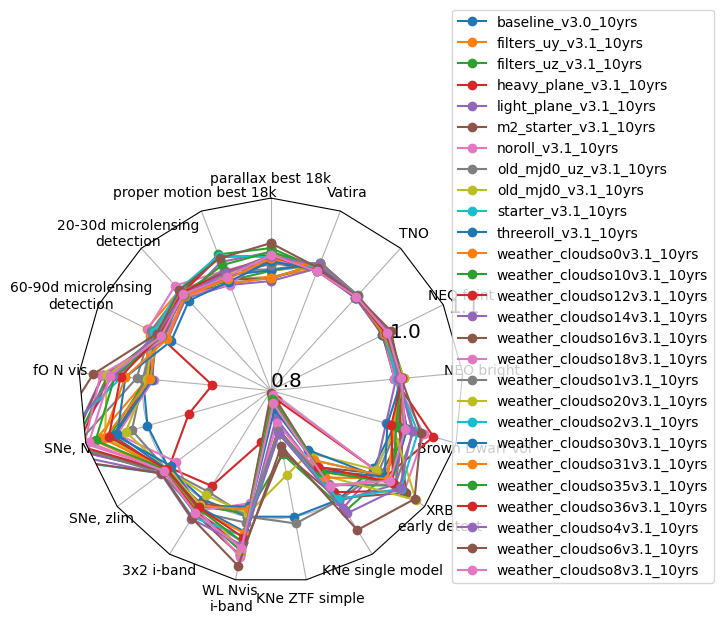

In [12]:
# only 3.x runs

runs = [run for run in data.index if '3.' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

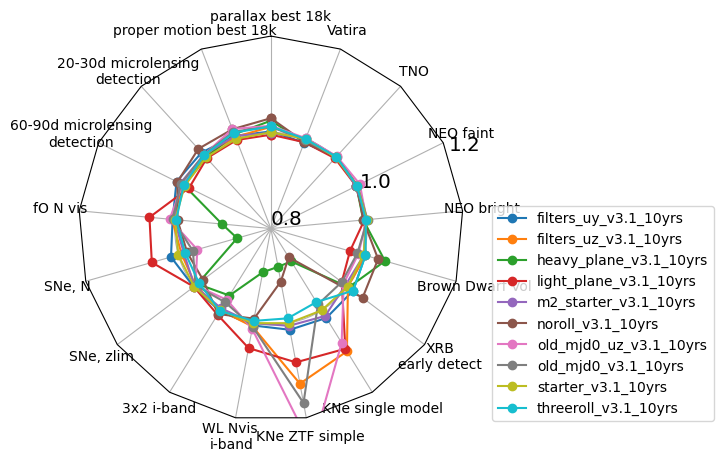

In [13]:
# only 3.1 runs, without the weather

runs = [run for run in data.index if '3.1' in run and 'weather' not in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

# Compare 3.1 and 3.0 median coadded depths.
# Changes of order 0.01 mags, so not really any change at all.

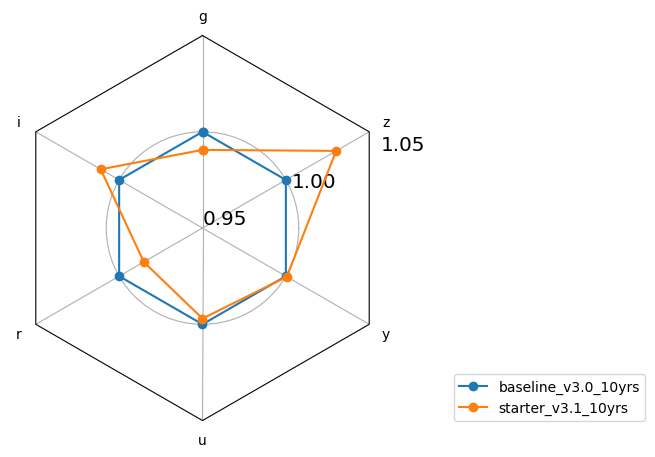

In [14]:
runs = ['baseline_v3.0_10yrs', 'starter_v3.1_10yrs']
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                mag_cols='all', norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

In [15]:
mag_data.loc[runs]

,g,i,r,u,y,z
baseline_v3.0_10yrs,26.688123,26.264600,26.818287,25.668262,24.756955,25.524781
starter_v3.1_10yrs,26.678730,26.275662,26.803522,25.665272,24.757543,25.554933


# Compare number of SNe in the DDFs
# Huge boost in all the DDFs.

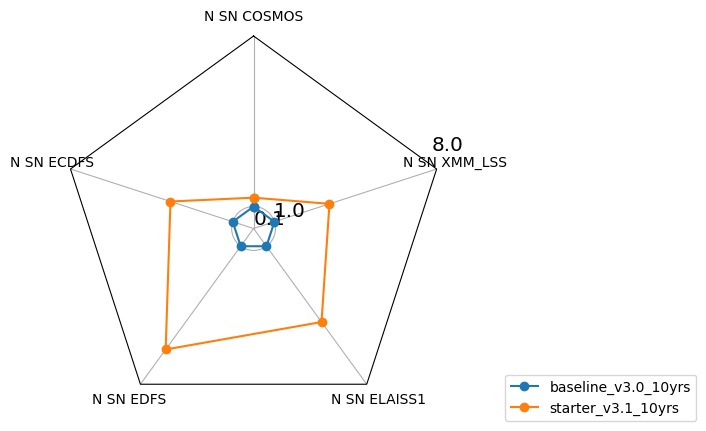

In [16]:
cols = [col for col in ddf_data.columns.values.tolist() if 'N SN' in col]

ndata = norm_df(ddf_data, runs, cols=cols,
                norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.1, 1.0, 8], bbox_to_anchor=(1.65, 0))

# SNe redshift limits in the DDFs. No big changes

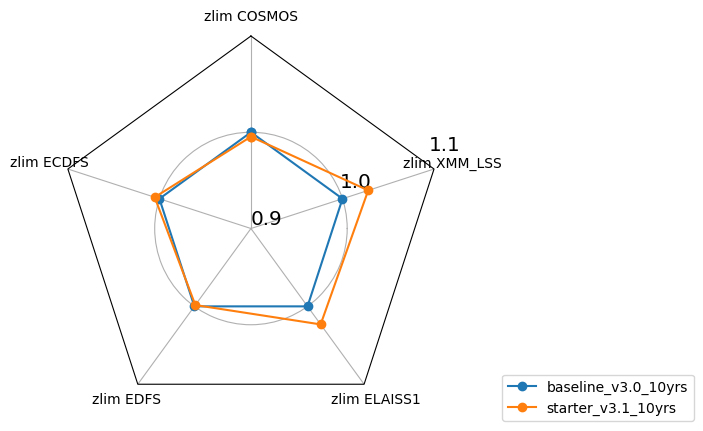

In [17]:
cols = [col for col in ddf_data.columns.values.tolist() if 'zlim' in col]

ndata = norm_df(ddf_data, runs, cols=cols,
                norm_run='baseline_v3.0_10yrs', mag_cols='all')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [18]:
ddf_data


,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS
baseline_v2.0_10yrs,47.333916,5.217382,NaN,81.438800,72.445437,0.596891,0.543027,NaN,0.593426,0.562289
baseline_v2.1_10yrs,21.899369,2.592571,NaN,40.212476,32.838014,0.594427,0.545216,NaN,0.594464,0.561932
baseline_v2.2_10yrs,13.647867,6.881372,NaN,3.753806,NaN,0.514987,0.577431,NaN,0.600156,NaN
baseline_v3.0_10yrs,362.726856,72.383449,74.734786,37.378088,60.363667,0.594675,0.575080,0.526724,0.546128,0.539335
filters_uy_v3.1_10yrs,392.762377,65.763333,119.798358,32.023350,52.775023,0.597429,0.571426,0.529098,0.596548,0.572319
filters_uz_v3.1_10yrs,374.244952,61.068424,110.006605,30.513217,53.148605,0.596875,0.562607,0.510613,0.577669,0.564340
heavy_plane_v3.1_10yrs,493.533022,266.220160,461.965305,179.479383,201.573909,0.590078,0.578689,0.528652,0.567352,0.567267
light_plane_v3.1_10yrs,491.971514,269.269845,460.472229,180.233452,203.569531,0.593998,0.578768,0.527194,0.569540,0.565674
m2_starter_v3.1_10yrs,494.101139,264.355229,461.416787,180.259516,206.582135,0.591394,0.578959,0.528695,0.569635,0.564779
noroll_v3.1_10yrs,494.925073,267.866337,465.262494,178.794823,203.893332,0.593970,0.580007,0.529172,0.569159,0.567492


In [19]:
data.index

Index(['baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
       'baseline_v3.0_10yrs', 'filters_uy_v3.1_10yrs', 'filters_uz_v3.1_10yrs',
       'heavy_plane_v3.1_10yrs', 'light_plane_v3.1_10yrs',
       'm2_starter_v3.1_10yrs', 'noroll_v3.1_10yrs', 'old_mjd0_uz_v3.1_10yrs',
       'old_mjd0_v3.1_10yrs', 'retro_baseline_v2.0_10yrs',
       'starter_v3.1_10yrs', 'threeroll_v3.1_10yrs',
       'weather_cloudso0v3.1_10yrs', 'weather_cloudso10v3.1_10yrs',
       'weather_cloudso12v3.1_10yrs', 'weather_cloudso14v3.1_10yrs',
       'weather_cloudso16v3.1_10yrs', 'weather_cloudso18v3.1_10yrs',
       'weather_cloudso1v3.1_10yrs', 'weather_cloudso20v3.1_10yrs',
       'weather_cloudso2v3.1_10yrs', 'weather_cloudso30v3.1_10yrs',
       'weather_cloudso31v3.1_10yrs', 'weather_cloudso35v3.1_10yrs',
       'weather_cloudso36v3.1_10yrs', 'weather_cloudso4v3.1_10yrs',
       'weather_cloudso6v3.1_10yrs', 'weather_cloudso8v3.1_10yrs'],
      dtype='object')

In [20]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs', 'starter_v3.1_10yrs']

In [21]:
sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_data

,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N","SNe, zlim",3x2 i-band,WL Nvis \ni-band,KNe ZTF simple,KNe single model,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,Vatira
retro_baseline_v2.0_10yrs,0.804328,0.176701,0.0883,0.1533,848.0,97124.012102,0.281304,34.632263,449.0,2763.0,3982.0,720.0,179640.718155,0.9048,0.623933,0.705953,NaN
baseline_v2.0_10yrs,0.791058,0.184088,0.3116,0.4284,839.0,99302.532220,0.282012,37.908126,443.0,3433.0,4544.0,1879.0,168086.074111,0.9294,0.642021,0.719635,0.0039
baseline_v2.1_10yrs,0.806910,0.188258,0.3111,0.4312,838.0,99294.339899,0.283756,38.560143,443.0,3585.0,4777.0,1918.0,163815.013503,0.9286,0.647553,0.723197,0.0017
baseline_v2.2_10yrs,0.792958,0.186345,0.3212,0.4462,830.0,112802.099640,0.289980,39.794283,440.0,3950.0,5215.0,1920.0,172453.127988,0.9304,0.657476,0.723913,0.0008
baseline_v3.0_10yrs,0.792666,0.185683,0.3239,0.4559,795.0,109475.798536,0.293926,38.643260,423.0,4308.0,5654.0,1950.0,168032.537231,0.9326,0.642155,0.722293,0.0376
starter_v3.1_10yrs,0.812579,0.189622,0.3214,0.4529,786.0,117022.524697,0.301720,39.093063,418.0,3442.0,5246.0,1991.0,170742.753616,0.9332,0.638248,0.720198,0.0499


# Major science metrics changes over simulation version

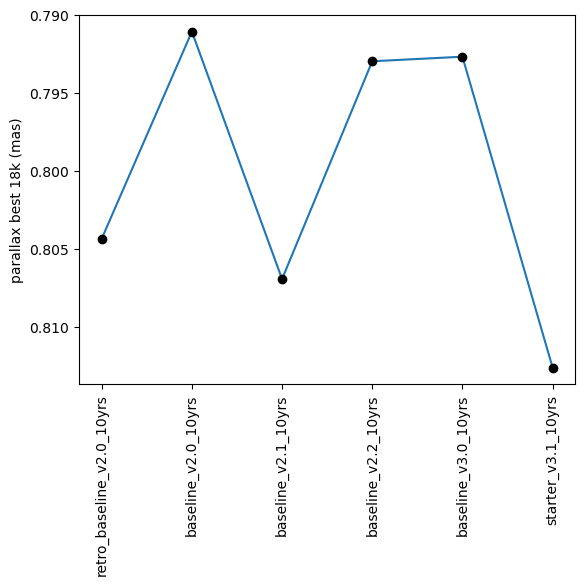

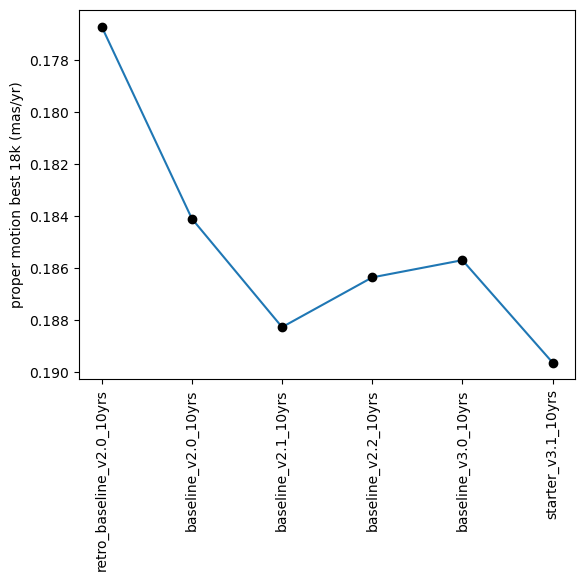

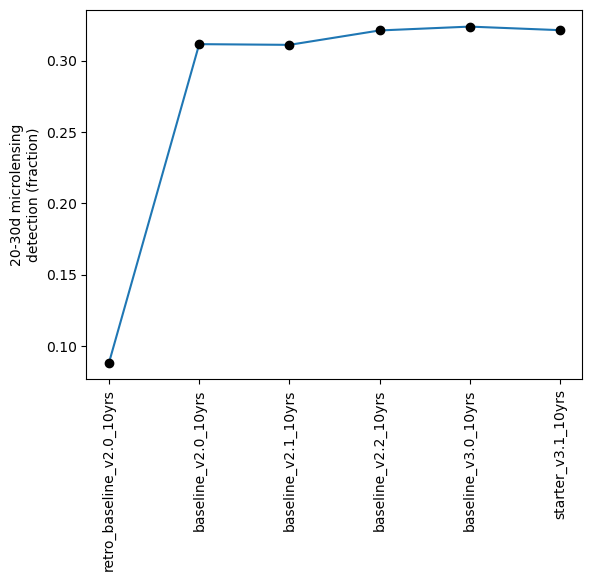

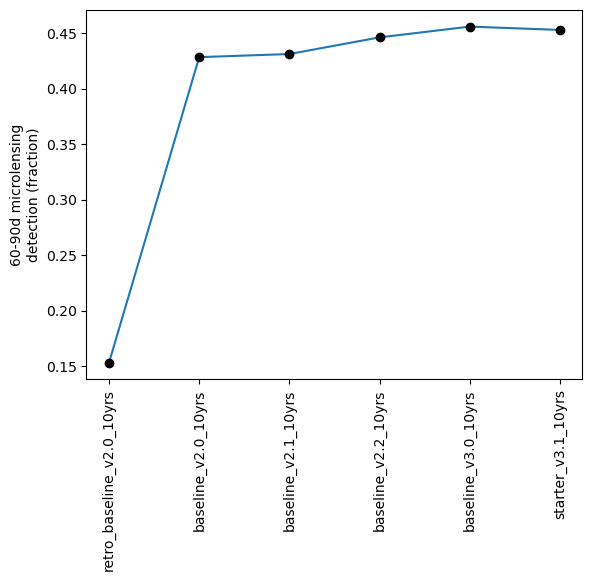

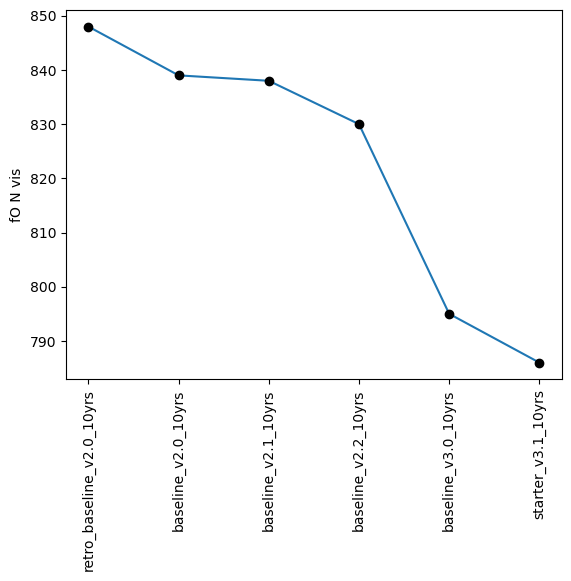

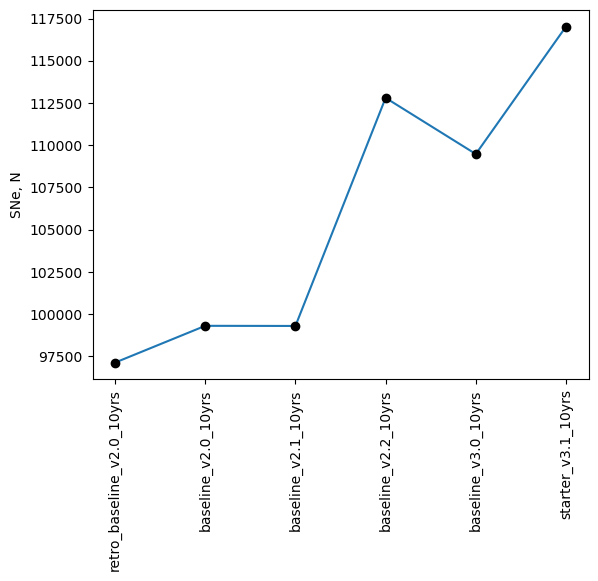

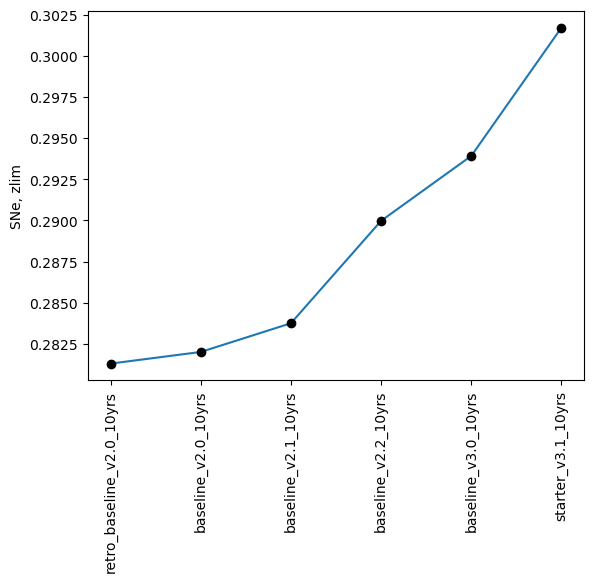

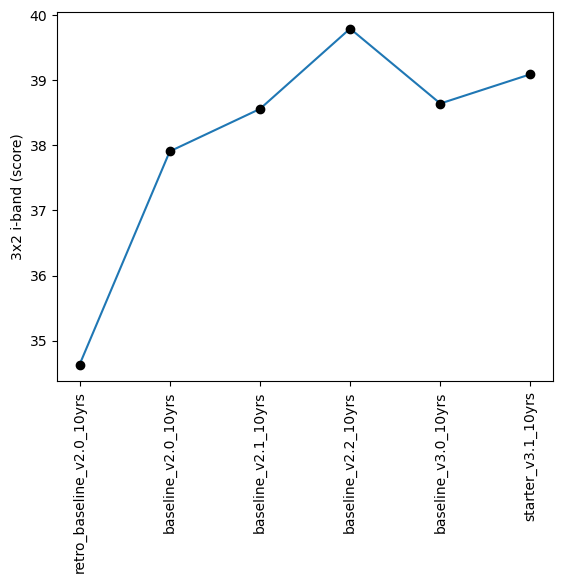

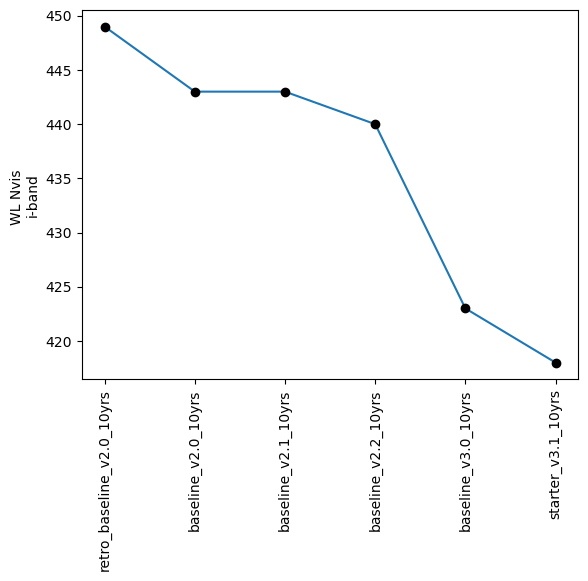

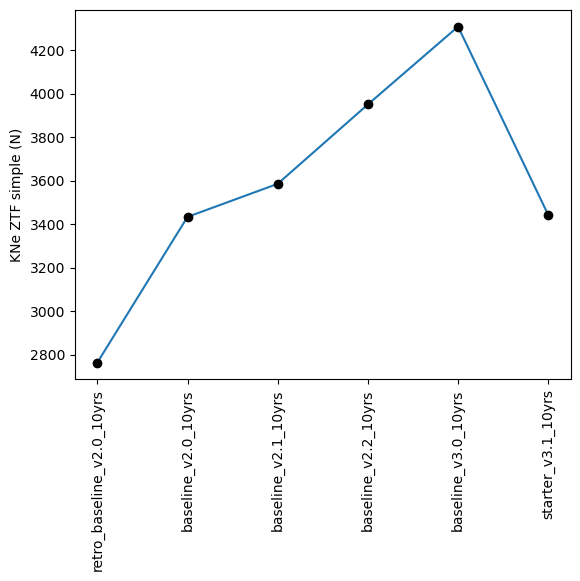

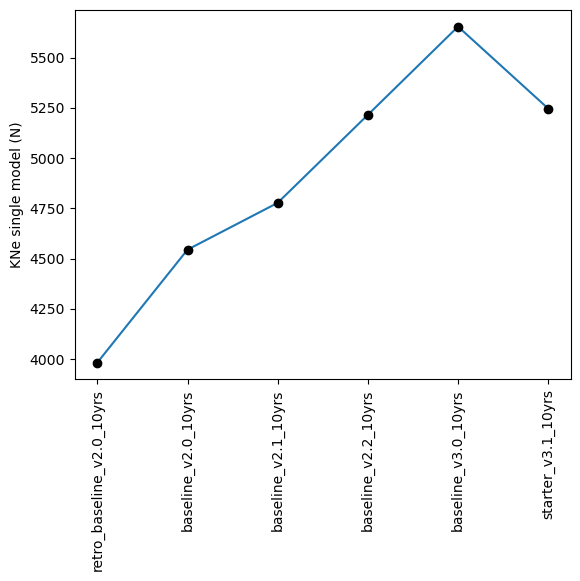

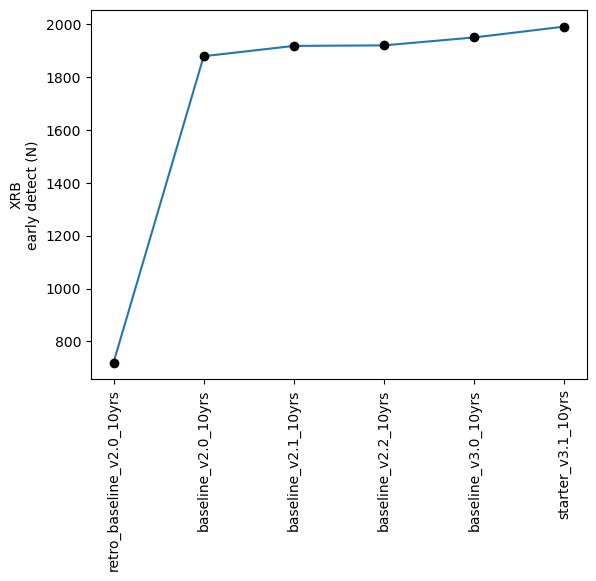

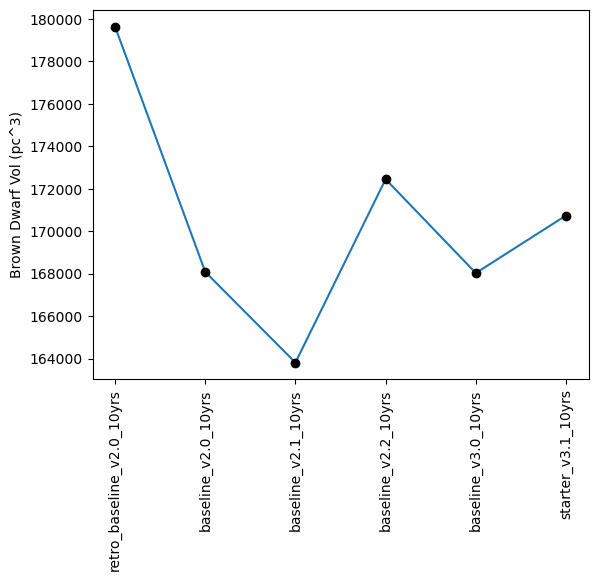

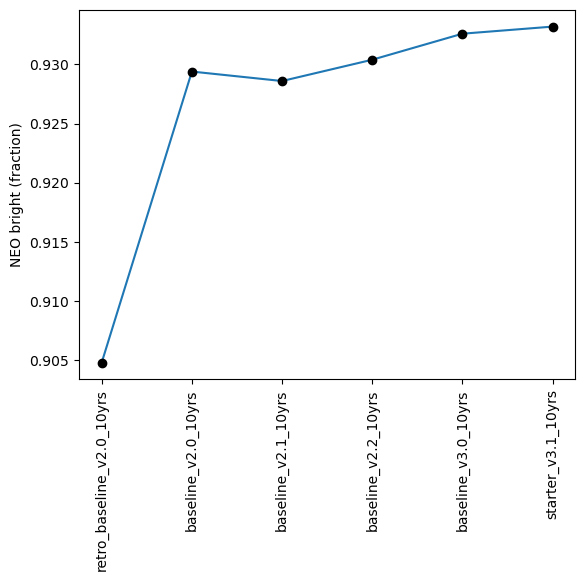

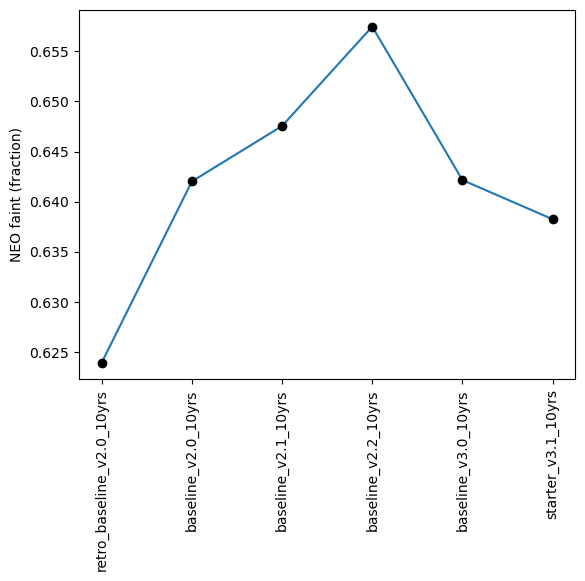

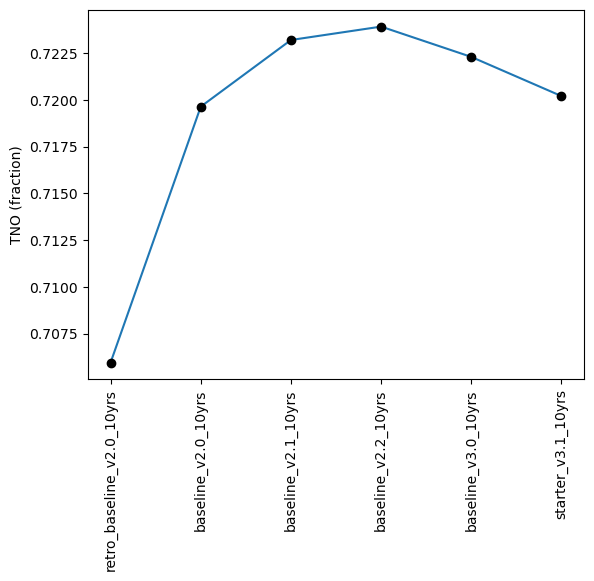

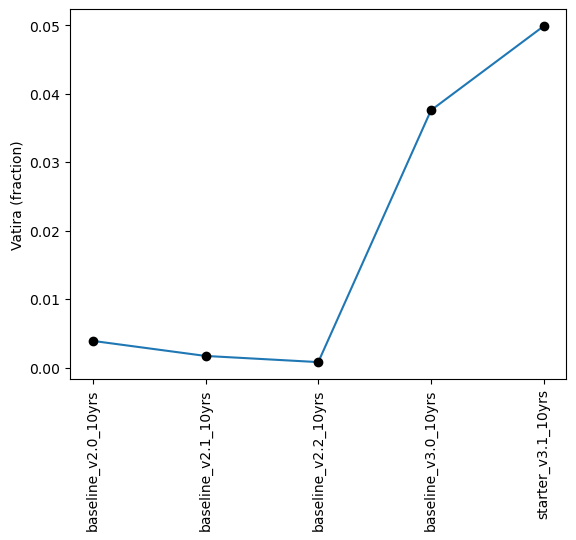

In [22]:
#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col])
    label_add = ''
    ax.plot(sub_data[col], 'ko')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

# DDF performance over simulation version

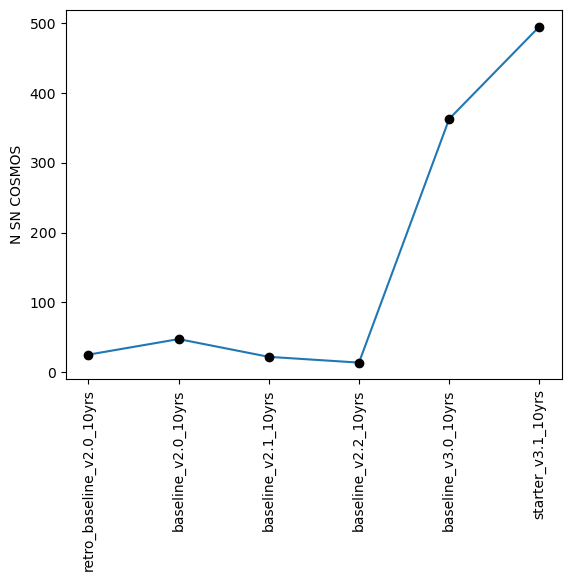

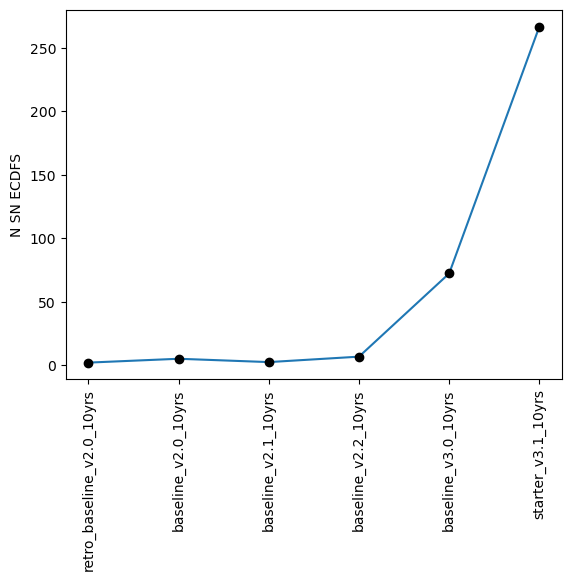

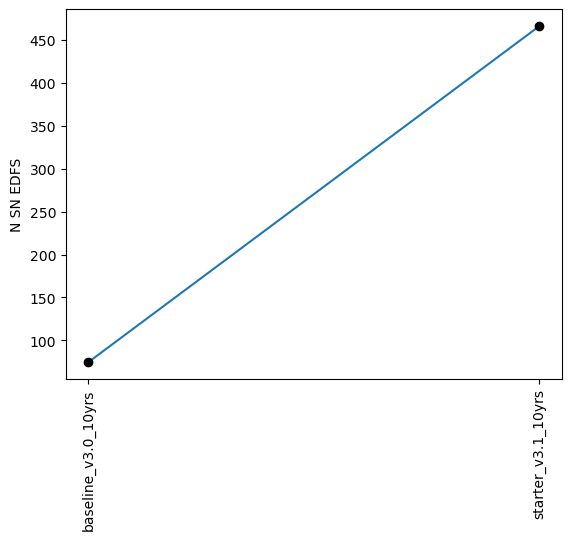

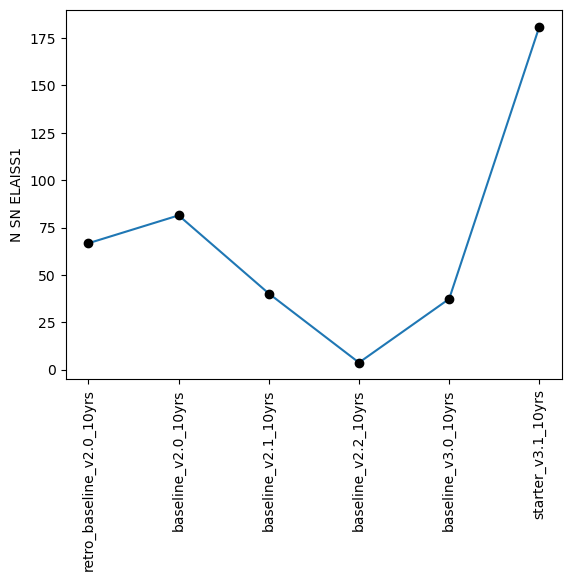

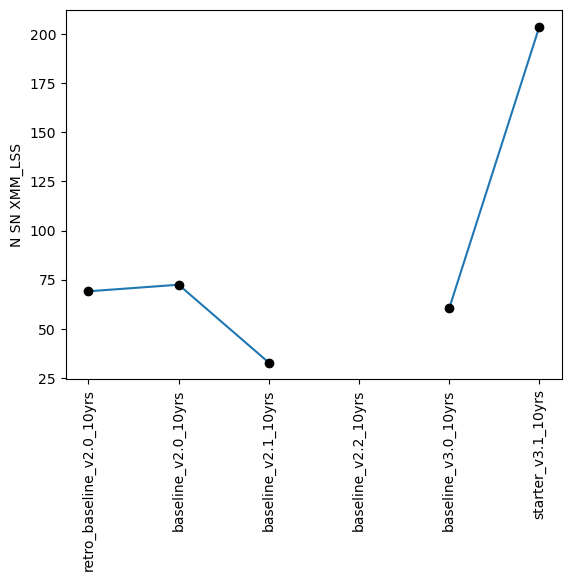

In [23]:

for col in sub_ddf.columns[0:5]:
    fig, ax = plt.subplots()
    ax.plot(sub_ddf[col])
    ax.plot(sub_ddf[col], 'ko')
    ax.set_ylabel(col)
    ax.tick_params(axis='x', labelrotation = 90)

In [24]:
# check that we have the depths and weighted seeing per year
cols = [col for col in data_loaded.columns if 'coadd g' in col and 'Median' in col]
data_loaded.loc['starter_v3.1_10yrs'][cols]

Median coadd g, year<1 night<365 and g HealpixSlicer      25.437598
Median coadd g, year<10 night<3652 and g HealpixSlicer    26.678456
Median coadd g, year<2 night<730 and g HealpixSlicer      25.778350
Median coadd g, year<3 night<1095 and g HealpixSlicer     26.070268
Median coadd g, year<4 night<1461 and g HealpixSlicer     26.244149
Median coadd g, year<5 night<1826 and g HealpixSlicer     26.342094
Median coadd g, year<6 night<2191 and g HealpixSlicer     26.432488
Median coadd g, year<7 night<2556 and g HealpixSlicer     26.510398
Median coadd g, year<8 night<2922 and g HealpixSlicer     26.564492
Median coadd g, year<9 night<3287 and g HealpixSlicer     26.618347
Name: starter_v3.1_10yrs, dtype: float64

In [25]:
cols = [col for col in data_loaded.columns if 'Median SNR-weighted FWHMeff g' in col]
data_loaded.loc['starter_v3.1_10yrs'][cols]

Median SNR-weighted FWHMeff g, year<1 night<365 and g HealpixSlicer      0.925549
Median SNR-weighted FWHMeff g, year<10 night<3652 and g HealpixSlicer    1.086049
Median SNR-weighted FWHMeff g, year<2 night<730 and g HealpixSlicer      0.970173
Median SNR-weighted FWHMeff g, year<3 night<1095 and g HealpixSlicer     0.985835
Median SNR-weighted FWHMeff g, year<4 night<1461 and g HealpixSlicer     0.980894
Median SNR-weighted FWHMeff g, year<5 night<1826 and g HealpixSlicer     1.003485
Median SNR-weighted FWHMeff g, year<6 night<2191 and g HealpixSlicer     1.024368
Median SNR-weighted FWHMeff g, year<7 night<2556 and g HealpixSlicer     1.048279
Median SNR-weighted FWHMeff g, year<8 night<2922 and g HealpixSlicer     1.078355
Median SNR-weighted FWHMeff g, year<9 night<3287 and g HealpixSlicer     1.084529
Name: starter_v3.1_10yrs, dtype: float64